This is a two hidden layer GAN with batch normalization based off of the "Intro to GANs" Lesson from the Udacity Deep Learning Foundations Nanodegree: https://github.com/udacity/deep-learning/blob/master/gan_mnist/Intro_to_GANs_Solution.ipynb 
As we can see, the model does train, but the figures it creates are not that impressive. 

In [2]:
%matplotlib inline
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [7]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.contrib.layers.batch_norm(h1)
        h1 = tf.maximum(alpha * h1, h1)
        h2 = tf.layers.dense(h1, n_units*3, activation=None)
        h2 = tf.contrib.layers.batch_norm(h2)
        h2 = tf.maximum(alpha * h2, h2)
        
        logits = tf.layers.dense(h2, out_dim)
        out = tf.tanh(logits)
        
        return out, logits

In [8]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1)
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

<h2>Hyperparameters</h2>

In [9]:
input_size = 784
z_size = 100
alpha = 0.01
smooth = 0.1

In [10]:
tf.reset_default_graph()
input_real, input_z = model_inputs(input_size, z_size)

g_model, g_logits = generator(input_z, input_size)
d_model_real, d_logits_real = discriminator(input_real)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

In [11]:
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

In [12]:
# learning_rate = 0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

In [13]:
!mkdir checkpoints

mkdir: checkpoints: File exists


In [14]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))          
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        losses.append((train_loss_d, train_loss_g))
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples, _ = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3835... Generator Loss: 4.2212
Epoch 2/100... Discriminator Loss: 0.3905... Generator Loss: 4.8789
Epoch 3/100... Discriminator Loss: 0.5342... Generator Loss: 4.7513
Epoch 4/100... Discriminator Loss: 0.6782... Generator Loss: 3.1819
Epoch 5/100... Discriminator Loss: 0.6444... Generator Loss: 2.1977
Epoch 6/100... Discriminator Loss: 1.0783... Generator Loss: 2.4338
Epoch 7/100... Discriminator Loss: 1.7846... Generator Loss: 1.1608
Epoch 8/100... Discriminator Loss: 1.7693... Generator Loss: 1.5836
Epoch 9/100... Discriminator Loss: 1.1042... Generator Loss: 2.1892
Epoch 10/100... Discriminator Loss: 1.9805... Generator Loss: 1.0366
Epoch 11/100... Discriminator Loss: 1.9280... Generator Loss: 1.6779
Epoch 12/100... Discriminator Loss: 1.3955... Generator Loss: 1.2712
Epoch 13/100... Discriminator Loss: 1.2094... Generator Loss: 1.2121
Epoch 14/100... Discriminator Loss: 1.5659... Generator Loss: 0.9615
Epoch 15/100... Discriminator Loss: 1.1497.

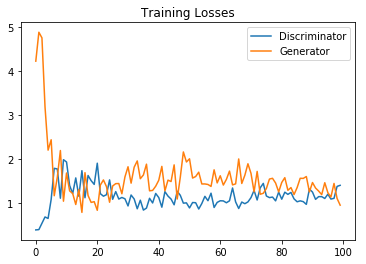

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [16]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

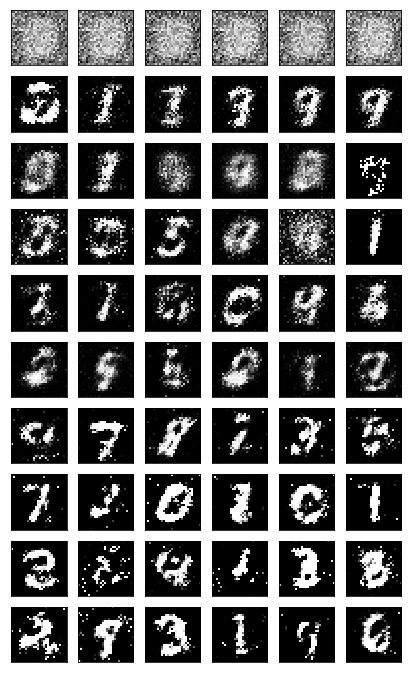

In [19]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)